In [1]:
import numpy as np
import pandas as pd
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import scipy.stats
from PIL import Image
import time
import math
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
import ipywidgets as widgets
import plotly.graph_objects as go
from ipywidgets import Layout

from sklearn.manifold import TSNE

from gensim.models import Word2Vec
from gensim.models import KeyedVectors

import matplotlib.pyplot as plt
from nltk.cluster import KMeansClusterer
import nltk
import sklearn
from sklearn import cluster
from sklearn import metrics
import gensim.downloader as api

from scipy.stats import mode
from sklearn.metrics import accuracy_score

#Ignore the "FutureWarning" on TSNE.
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings(
    action='ignore',
    category=FutureWarning,
    module=r'.*_t_sne'
)


Load and save googles w2v model.

In [2]:
#Uncomment to fetch the model
#loaded_w2v = api.load('word2vec-google-news-300')
model_file_name = "this-gensim-model"

#Uncomment to save the model in current directory
#loaded_w2v.save(model_file_name)

Load the model from the saved file name

In [3]:
w2v = KeyedVectors.load(model_file_name)

Generate temporary file and store the model there.

In [4]:
#import tempfile

#with tempfile.NamedTemporaryFile(prefix='gensim-model-', delete=False) as tmp:
#    temporary_filepath = tmp.name
#    loaded_w2v.save(temporary_filepath)
    #
    # The model is now safely stored in the filepath.
    # You can copy it to other machines, share it with others, etc.
    #
    # To load a saved model:
    #
#    w2v = KeyedVectors.load(temporary_filepath)

Save the model.

In [5]:
DF = pd.read_csv("philosophy_data.csv")

DF["NumOfWords"]=DF["sentence_str"].apply(lambda x: len(x.split(" ")))
DF.head()
print(DF['tokenized_txt'][0])
print(len(DF))

#Remove rows in the dataframe that are empty
empty_sentences = []
for index, sentence in enumerate(DF['tokenized_txt']):
    if len(sentence.strip("[]")) == 0:
        empty_sentences.append(index)
print(empty_sentences)
DF.drop(DF.index[empty_sentences], inplace=True)
print(len(DF))
#Reset index of dataframe when removing rows.
DF.reset_index(drop = True, inplace = True)

['what', 'new', 'socrates', 'to', 'make', 'you', 'leave', 'your', 'usual', 'haunts', 'in', 'the', 'lyceum', 'and', 'spend', 'your', 'time', 'here', 'by', 'the', 'king', 'archon', 'court']
360808
[66294, 66295, 66296, 66297, 150420, 150422, 152817, 154482, 154483, 158010, 179659, 285758]
360796


Extract the tokenized_txt DF["tokenized_txt"] sentences and append them into a python list.

In [6]:
def collect_sentences_from_tokenized_txt(sentences, tokenized_txt):
  #Ship those sentences that are empty
  for i, sentence in enumerate(tokenized_txt):
    sentences.append(sentence)
  return sentences

In [7]:
sentences = []
collect_sentences_from_tokenized_txt(sentences, DF["tokenized_txt"])
sentences[:5]

["['what', 'new', 'socrates', 'to', 'make', 'you', 'leave', 'your', 'usual', 'haunts', 'in', 'the', 'lyceum', 'and', 'spend', 'your', 'time', 'here', 'by', 'the', 'king', 'archon', 'court']",
 "['surely', 'you', 'are', 'not', 'prosecuting', 'anyone', 'before', 'the', 'king', 'archon', 'as', 'am']",
 "['the', 'athenians', 'do', 'not', 'call', 'this', 'prosecution', 'but', 'an', 'indictment', 'euthyphro']",
 "['what', 'is', 'this', 'you', 'say']",
 "['someone', 'must', 'have', 'indicted', 'you', 'for', 'you', 'are', 'not', 'going', 'to', 'tell', 'me', 'that', 'you', 'have', 'indicted', 'someone', 'else']"]

Apply and train our own Word2Vec to sentences (Doc2Vec also exists in gensim.models)

In [8]:
#model = Word2Vec(sentences = sentences, min_count = 1)

Apply the already trained Word2Vec model from Google News dataset that contains about 100 billion words.
There's possibility to train our own model on our own data but the results might be worse.

In [9]:

# for index, word in enumerate(w2v.index_to_key):
#   if index == 10:
#     break
#   print("word #{}/{} is {}".format(index, len(w2v.index_to_key), word))

# pairs = [
#     ('car', 'minivan'),   # a minivan is a kind of car
#     ('car', 'bicycle'),   # still a wheeled vehicle
#     ('car', 'airplane'),  # ok, no wheels, but still a vehicle
#     ('car', 'cereal'),    # ... and so on
#     ('car', 'communism'),
# ]
# for w1, w2 in pairs:
#     print('%r\t%r\t%.2f' % (w1, w2, w2v.similarity(w1, w2)))

# print(w2v.most_similar(positive=['car', 'minivan'], topn=5))
# print(w2v.doesnt_match(['fire', 'water', 'land', 'sea', 'air', 'car']))

This function summarizes each vectorized word in a sentence and divides the sum with the amount of words in the sentence.
Doing this will allow us to be able to get whole sentences vectorized values instead of individual words.

In [10]:
def sentence_vectorizer(sentence, model):
    words = []
    num_words = 0
    for index, w in enumerate(sentence):
        try:
            if num_words == 0:
                words = model[w]
            else:
                words = np.add(words, model[w])
            num_words += 1
        except:
            pass
    return np.asarray(words) / num_words

Use the above function with our model (in this case w2v) sentences.

In [11]:
features = []
num = 0
for index, sentence in enumerate(sentences):
    temp_variable = sentence_vectorizer(sentence, w2v)
    #Check if np.array is empty
    features.append(temp_variable)
    num += 1
    if num % 50000 == 0:
        print(num)

50000
100000
150000
200000
250000
300000
350000


In [12]:
print(sentences[0])
temp_list = [word for word in sentence[0]]
#Indexes of sentences that was emtpy inside of sentences

#They should be equal
print(len(features))
print(len(sentences))
#print(features[0])

['what', 'new', 'socrates', 'to', 'make', 'you', 'leave', 'your', 'usual', 'haunts', 'in', 'the', 'lyceum', 'and', 'spend', 'your', 'time', 'here', 'by', 'the', 'king', 'archon', 'court']
360796
360796


In [13]:
schools = DF["school"].unique().tolist()
print(schools)
NUM_CLUSTERS = len(schools)

['plato', 'aristotle', 'empiricism', 'rationalism', 'analytic', 'continental', 'phenomenology', 'german_idealism', 'communism', 'capitalism', 'stoicism', 'nietzsche', 'feminism']


This takes to long. A possible solution to this is to use t-SNE to reduce the dimension from 300 to 50 or smth.

In [14]:
# start = time.time()
#
# kClusterer = KMeansClusterer(NUM_CLUSTERS, distance=nltk.cluster.util.cosine_distance, repeats=25)
# assigned_clusters = kClusterer.cluster(features[:500], assign_clusters=True)
#

In [15]:
start = time.time()

kmeans = cluster.KMeans(n_clusters=NUM_CLUSTERS, random_state=0)
kmeans.fit(features)
labels = kmeans.predict(features)
centroids = kmeans.cluster_centers_

end = time.time()
print(end - start)

201.78426313400269


In [16]:
silhouette_score = metrics.silhouette_score(features[:10000], labels[:10000], metric='euclidean')
print(silhouette_score)

0.013899244


In [17]:
#Compare the labels indexes with features/sentences
# print(kmeans.cluster_centers_.shape)
# print(labels)
# print(kmeans.labels_)
centroids = kmeans.cluster_centers_
# print(centroids)
print(kmeans.labels_)
print(labels)
print(labels[:5])

label_dict = dict.fromkeys(list(set(labels)), 0)
for cluster in labels:
    label_dict[cluster] += 1

print(label_dict)


[ 8  8 10 ...  8  4  1]
[ 8  8 10 ...  8  4  1]
[ 8  8 10  7  8]
{0: 41925, 1: 22122, 2: 29177, 3: 20791, 4: 41861, 5: 21889, 6: 44194, 7: 13179, 8: 39447, 9: 15159, 10: 35784, 11: 13806, 12: 21462}


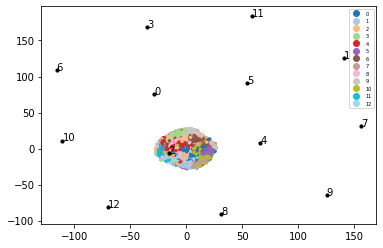

5140.296327352524


In [18]:
#Trying the scatter plot:
start = time.time()
model = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)

unique_labels_list = list(set(labels))
Y=model.fit_transform(features[:250000])
CENTER=model.fit_transform(centroids)

scatter = plt.scatter(Y[:, 0], Y[:, 1], c=labels[:250000], s=5, cmap='tab20')
plt.legend(handles=scatter.legend_elements()[0], labels=unique_labels_list, prop={"size":5})

plt.scatter(CENTER[:,0], CENTER[:,1], c='black', s=10)

for j in range(len(centroids)):
    plt.annotate(unique_labels_list[j], xy=(CENTER[j][0], CENTER[j][1]), xytext=(0,0), textcoords='offset points')

plt.show()

end = time.time()
print(end - start)

Combine the kmeans clustering results with the labels.

Put the kmeans result in a dictionary:

In [19]:
# from sklearn.metrics import accuracy_score
# accuracy_score(DF["school"],[schools[index] for index in labels])

#Must find a way to assign each cluster to each school. This way is not optimal and doesn't result in a good assignment (but it's something).

realVsPredLabels = np.zeros_like(labels)
for i, school in enumerate(schools):
    mask = (labels == i)
    realVsPredLabels[mask] = mode([schools.index(val) for val in DF["school"][mask]])[0]

accuracy_score(labels, realVsPredLabels)


0.11602401356999523

In [20]:
pred = pd.DataFrame([schools[index] for index in realVsPredLabels])
pred.columns = ['Predicted School of Thought']

print(len(DF["school"]))
print(len(pred))
prediction = pd.concat([DF["school"], pred], axis = 1)
print(len(prediction))
prediction.head()

360796
360796
360796


,school,Predicted School of Thought
0,plato,aristotle
1,plato,aristotle
2,plato,aristotle
3,plato,analytic
4,plato,aristotle


In [21]:
temp_indexes = []
for index, val in enumerate(prediction['school']):
    if val not in schools:
        temp_indexes.append(index)

test_concat = {'School': DF['school'],
               'Predicted School': pred}
test_df = pd.DataFrame(test_concat, columns=['School', 'Predited School'])
# print(test_df['School'][temp_indexes])

In [22]:
# Create dict with values:
# SOT = school of thought
# result_dict = {1st SOT: {1st predicted SOT: amount predicted 1st SOT,
#                          2nd predicted SOT: amount predicted 2nd SOT
#                          ... },
#                2nd SOT: {....},
#                ....
#                }

In [23]:
result_dict = dict()
for index, school in enumerate(prediction['school']):
    if result_dict.get(school) is None:
        result_dict[school] = dict.fromkeys(schools, 0)
    predSchool = prediction['Predicted School of Thought'][index]
    if result_dict[school].get(predSchool) is None:
        result_dict[school][predSchool] = 1
    else:
        result_dict[school][predSchool] += 1

print(result_dict)
#print(prediction.iloc[indices, :])

{'plato': {'plato': 3146, 'aristotle': 16794, 'empiricism': 0, 'rationalism': 0, 'analytic': 16156, 'continental': 0, 'phenomenology': 0, 'german_idealism': 2270, 'communism': 0, 'capitalism': 0, 'stoicism': 0, 'nietzsche': 0, 'feminism': 0}, 'aristotle': {'plato': 1223, 'aristotle': 21729, 'empiricism': 0, 'rationalism': 0, 'analytic': 19971, 'continental': 0, 'phenomenology': 0, 'german_idealism': 5852, 'communism': 0, 'capitalism': 0, 'stoicism': 0, 'nietzsche': 0, 'feminism': 0}, 'empiricism': {'plato': 566, 'aristotle': 8562, 'empiricism': 0, 'rationalism': 0, 'analytic': 8505, 'continental': 0, 'phenomenology': 0, 'german_idealism': 2298, 'communism': 0, 'capitalism': 0, 'stoicism': 0, 'nietzsche': 0, 'feminism': 0}, 'rationalism': {'plato': 742, 'aristotle': 9888, 'empiricism': 0, 'rationalism': 0, 'analytic': 9834, 'continental': 0, 'phenomenology': 0, 'german_idealism': 2485, 'communism': 0, 'capitalism': 0, 'stoicism': 0, 'nietzsche': 0, 'feminism': 0}, 'analytic': {'plato': 

X axis are the real SOT:s and Y axis are the amount of assigned SOT:s our algorithm assigned to the real SOT.

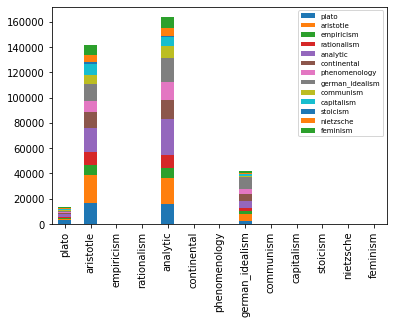

In [24]:
combined_bar = pd.DataFrame(result_dict)
# print(combined_bar)
# combined_bar.plot.bar()
# print(result_dict)
combined_bar.plot(kind="bar", stacked=True)
plt.legend(prop={"size":7})
plt.show()

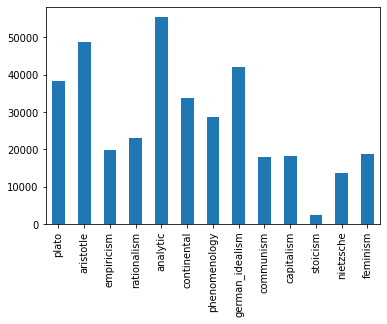

In [25]:
# Show the total amount of real assigned SOT on each text. Compare this correct plot with the above.
total_dict = dict.fromkeys(schools, 0)
for school in prediction['school']:
    total_dict[school] += 1

plot_total_dict = pd.Series(total_dict)
# print(plot_total_dict)
plot_total_dict.plot(kind="bar")
plt.show()

Scatter plot.